In [1]:
import matplotlib.pyplot as plt
import numpy as np

### Basic functions

In [2]:
# Cell with the functions

a1, a2, b1, b2 = 0.1, -0.1, 0.1, -0.12

def explicit_euler_calculation(x, times, h, sigma1, sigma2, I = None):
    x_current = np.array(x)
    if I is None:
        I = np.random.normal(0, np.sqrt(h), 2)
    x_current[0] = x[0] + (b1 - a1*x[1])*x[0]*h + sigma1*x[0]*I[0]
    x_current[1] = x[1] + (b2 - a2*x[0])*x[1]*h + sigma2*x[1]*I[1]   

    return x_current

def patankar_euler_calculation(x, times, h, sigma1, sigma2, I = None):
    x_current = np.array(x)
    if I is None:
        I = np.random.normal(0, np.sqrt(h), 2)
    x_current[0] = (x[0] + b1*x[0]*h + sigma1*x[0]*I[0]) / (1 + a1*x[1]*h)
    x_current[1] = (x[1] + b2*x[1]*h + sigma2*x[1]*I[1]) / (1 + a2*x[0]*h)
    return x_current

def stochastic_patankar_euler_calculation(x, times, h, sigma1, sigma2, I= None):
    x_current = np.array(x)
    if I is None:
        I = np.random.normal(0, np.sqrt(h), 2)
    x_current[0] = (x[0] + b1*x[0]*h) / (1 + a1*x[1]*h - sigma1*I[0] + (sigma1*I[0])**2)
    x_current[1] = (x[1] + b2*x[1]*h) / (1 + a2*x[0]*h - sigma2*I[1] + (sigma2*I[1])**2)
    return x_current


### Methods 

In [3]:
def stochastic_patankar_method(times, h, sigma1, sigma2, initial_cond, I = None ):
    x = np.zeros((len(times), 2))
    x[0] = initial_cond
    x_current = initial_cond

    for i in range(1, len(times)):
        time = times[i]
        
        spec = stochastic_patankar_euler_calculation(x_current, time, h, sigma1, sigma2, I[i])

        for j in range(2):
                x[i, j] = spec[j]
        x_current = x[i]

    return x


def composite_euler_method(times, h, sigma1, sigma2, initial_cond, I = None ):
    x = np.zeros((len(times), 2))
    x[0] = initial_cond
    x_current = initial_cond

    for i in range(1, len(times)):
        time = times[i]
        
        pec = patankar_euler_calculation(x_current, time, h, sigma1, sigma2, I[i])
        spec = stochastic_patankar_euler_calculation(x_current, time, h, sigma1, sigma2, I[i])

        for j in range(2):
            if pec[j] > 0:
                x[i, j] = pec[j]
            else:
                x[i, j] = spec[j]
        x_current = x[i]

    return x


def fully_composite_euler_method(times, h, sigma1, sigma2, initial_cond, I = None):

    x = np.zeros((len(times), 2))
    x[0] = initial_cond
    x_current = initial_cond

    for i in range(1, len(times)):
        time = times[i]

        if I is None:
            eec = explicit_euler_calculation(x_current, time, h, sigma1, sigma2)
            pec = patankar_euler_calculation(x_current, time, h, sigma1, sigma2)
            spec = stochastic_patankar_euler_calculation(x_current, time, h, sigma1, sigma2)
        else: 
            eec = explicit_euler_calculation(x_current, time, h, sigma1, sigma2, I[i])
            pec = patankar_euler_calculation(x_current, time, h, sigma1, sigma2, I[i])
            spec = stochastic_patankar_euler_calculation(x_current, time, h, sigma1, sigma2, I[i])

        for j in range(2):
            if eec[j] > 0:
                x[i, j] = eec[j]
            elif pec[j] > 0:
                x[i, j] = pec[j]
            else:
                x[i, j] = spec[j]
        x_current = x[i]

    return x

### Secondary functions

In [4]:
def wierner_increments(matrix, step):

    num_rows, num_cols = matrix.shape
    aggregated_rows = num_rows // step
    remainder = num_rows % step

    result = np.zeros((aggregated_rows + (1 if remainder > 0 else 0), num_cols))

    for i in range(aggregated_rows):
        result[i] = np.sum(matrix[i*step:(i+1)*step], axis=0)
    
    if remainder > 0:
        result[-1] = np.sum(matrix[aggregated_rows*step:], axis=0)
    
    return result

def simulate_system(times, h, sigma1, sigma2, initial_cond, I=None, sim = 'fully'):
    steps = len(times)
    
    # Generate shared random values if not provided
    if I is None:
        I = np.random.normal(0, np.sqrt(h), (steps, 2))
    
    if sim == 'fully':
        x = fully_composite_euler_method(times, h, sigma1, sigma2, initial_cond, I)
    elif sim == 'composite':
        x = composite_euler_method(times, h, sigma1, sigma2, initial_cond, I)
    else:
        x = stochastic_patankar_method(times, h, sigma1, sigma2, initial_cond, I)

    return x, I

### Tests and results

##### The graph overlapped
Now I'm going to test if the functions are working, and I will test overlapping the graphs as we have in the article

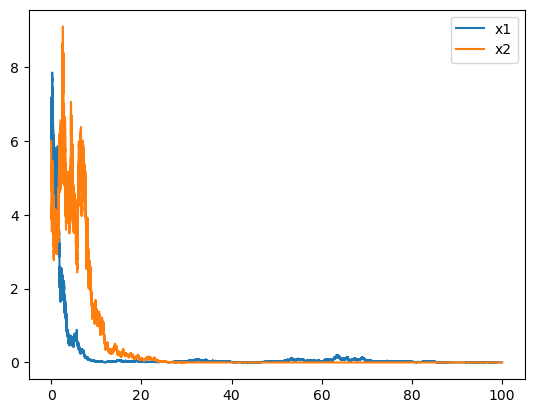

In [5]:
h = 1/(2**15)
times = np.arange(0,100 ,h)
x, I = simulate_system(times, h, 0.5, 0.5, [6,6] , sim = 'fully')

plt.plot(times, x[:, 0], label = 'x1')
plt.plot(times, x[:, 1], label = 'x2')
plt.legend()
plt.show()

In [6]:
h_coarse = 1/(2**4)
times_coarse = np.arange(0,100 ,h_coarse)
y = fully_composite_euler_method(times_coarse, h_coarse, 0.5, 0.5, 
                                 [6,6], wierner_increments(I, 2**11))


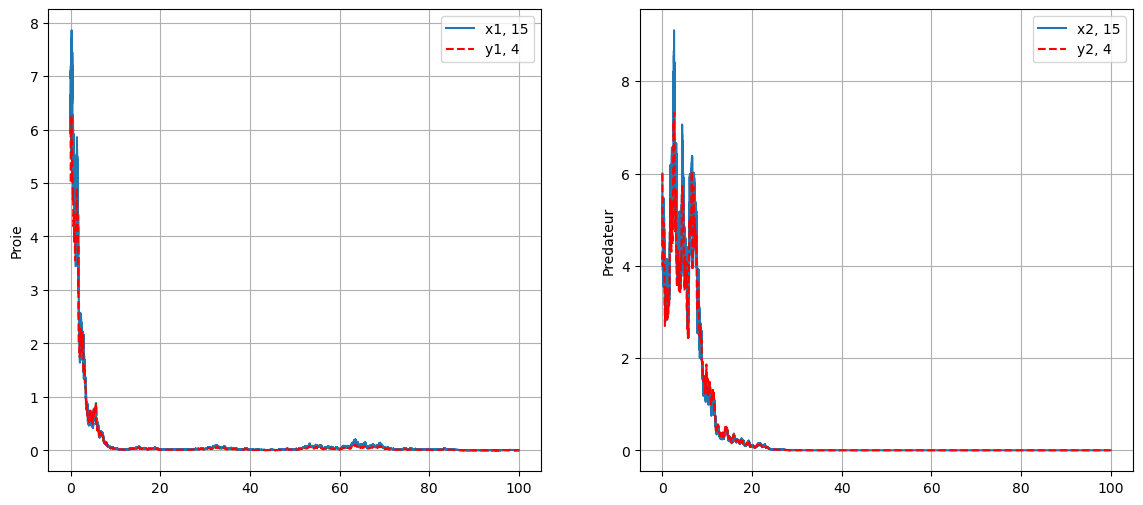

In [7]:
fig, ax = plt.subplots(1,2, figsize = (14,6))

ax[0].plot(times, x[:, 0], label = 'x1, 15')
ax[0].plot(times_coarse, y[:, 0], label = 'y1, 4', color = 'red', linestyle = '--')
ax[0].set_ylabel('Proie')

ax[1].plot(times, x[:, 1], label = 'x2, 15')
ax[1].plot(times_coarse, y[:, 1], label = 'y2, 4', color = 'red', linestyle= '--')
ax[1].set_ylabel('Predateur')

ax[0].legend()
ax[1].legend()

ax[0].grid(True)
ax[1].grid(True)


##### Now I will do the graph of the error

In [9]:
stepsizes = [1/(2**i) for i in range(10, 3, -1)] 

for i in range(10,3,-1):

    h_coarse = 1/(2**i)
    times_coarse = np.arange(0,100 ,h_coarse)
    y = fully_composite_euler_method(times_coarse, h_coarse, 0.5, 0.5, 
                                 [6,6], wierner_increments(I, 2**(15-i)))
    fig, ax = plt.subplots(1,2 , figsize = (10,4))
    ax[0].plot(times_coarse , y[:, 0], label = f'x1 , 2**{-i}')
    ax[0].plot(times, x[:, 0], color = 'red', linestyle = '--')
    ax[1].plot(times_coarse , y[:, 1], label = f'x2 , 2**{-i}')
    ax[1].plot(times, x[:, 1], color = 'red', linestyle = '--')

    ax[0].set_xlabel('Proie')
    ax[1].set_ylabel('Predateur')
    
    ax[0].legend()
    ax[1].legend()

    ax[0].grid(True)
    ax[1].grid(True)


: 

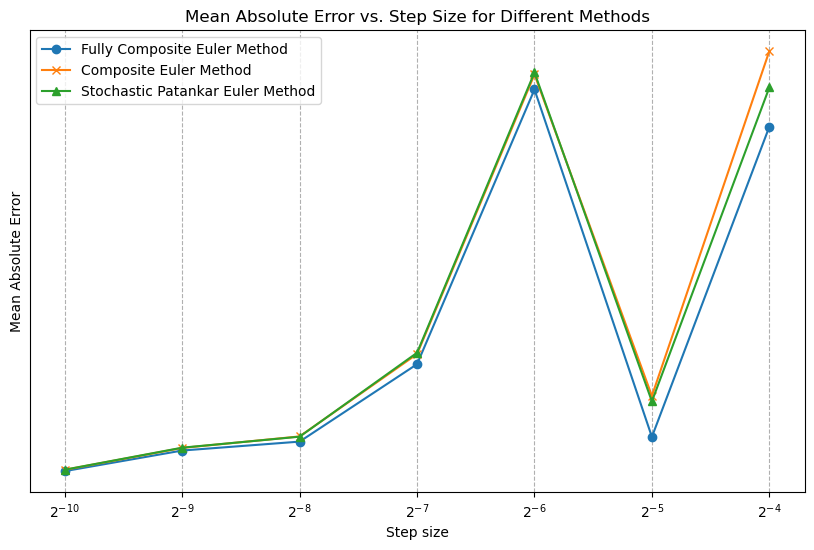

In [8]:
# Define the stepsizes and initialize the error storage
stepsizes = [1/(2**i) for i in range(10, 3, -1)]  # From 2^-10 to 2^-4
errors_fully_composite = []
errors_composite_euler = []
errors_stoch_patankar = []

# Reference solution from fine stepsize
reference_solution = x  # Results from the fine stepsize 1/(2**12)
times_fine = times

sigma1, sigma2 = 0.2, 0.2
initial_conditions = [6,6]

def calculate_mae(simulation, reference):
    # Mean Absolute Error calculation
    return np.mean(abs(simulation - reference))

# Iterate over each coarser stepsize
for h in stepsizes:
    step_ratio = int(h*(2**15))
    
    adjusted_random_values = wierner_increments(I, step_ratio)

    results_fully_composite, _ = simulate_system(times_fine[::step_ratio], h, sigma1, sigma2, initial_conditions, adjusted_random_values, sim = 'fully')
    errors_fully_composite.append(calculate_mae(results_fully_composite, reference_solution[::step_ratio]))

    results_composite_euler, _ = simulate_system(times_fine[::step_ratio], h, sigma1, sigma2, initial_conditions, adjusted_random_values, sim = 'composite')
    errors_composite_euler.append(calculate_mae(results_composite_euler, reference_solution[::step_ratio]))
    
    results_stoch_patankar, _ = simulate_system(times_fine[::step_ratio], h, sigma1, sigma2, initial_conditions, adjusted_random_values, sim = 'stoch')
    errors_stoch_patankar.append(calculate_mae(results_stoch_patankar, reference_solution[::step_ratio]))

# Plotting
plt.figure(figsize=(10, 6))
plt.xscale('log', base =2)
plt.yscale('log', base =2)
plt.plot(stepsizes, errors_fully_composite, label='Fully Composite Euler Method', marker='o')
plt.plot(stepsizes, errors_composite_euler, label='Composite Euler Method', marker='x')
plt.plot(stepsizes, errors_stoch_patankar, label='Stochastic Patankar Euler Method', marker='^')
plt.xlabel('Step size')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error vs. Step Size for Different Methods')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()


In [28]:
print(errors_stoch_patankar)
print(errors_composite_euler)
print(errors_fully_composite)

[0.6275685004774502, 0.44617455864126243, 0.6480720461317379, 0.5900818907828154, 0.5340602078602243, 0.5047939500520954, 0.45831281842292143]
[0.6275189989246139, 0.44613683363897216, 0.6481112117892485, 0.5881055722286876, 0.5334958274193496, 0.5084785823421076, 0.46070687963371815]
[0.6265645599390662, 0.4450431581506079, 0.644179528831869, 0.580763119423494, 0.5204168444532387, 0.4842652191172722, 0.42059640407277965]
